# Convert Audio Files to Star-scale Spectrograms
June 20th, 2024

*Chen, S., Thielk, M., & Gentner, T. Q. (2024). Auditory Feature-based Perceptual Distance. bioRxiv, 2024.02.28.582631. https://doi.org/10.1101/2024.02.28.582631*

### Overview of Auditory Feature-based Perceptual Distance (APD):
1. Convert audio files to species-specific frequency scaled spectrogram **(You are here!)**
 - Part I: 
     - Load audio
     - Segment audio
 - Part II:
     - Spectrogram audio
 
 
2. Pre-train convolutional neural network (CNN) to learn spectrogram features
3. Fine-tune CNN with behavioral data

# Part I

## Load Audio files
Here we will be using a publicly available library of starling songs within a local directory. 

*Arneodo, Z., Sainburg, T., Jeanne, J., & Gentner, T. (2019). An acoustically isolated European starling song library [dataset]. Zenodo. https://doi.org/10.5281/zenodo.3237218*


In [1]:
import os
import glob

import pandas as pd
import numpy as np
import apd.helpers.general

In [2]:
## I am importing local directories of where things are in this file
### ZENODO_DIR refers to the directory for the Zenodo song dataset
### DATA_DIR refers to an un-uploaded data folder in this repo. Prior to this notebook it is empty.
from apd.utils.paths import ZENODO_DIR, DATA_DIR

### Collect audio file locations

In [3]:
wavs = glob.glob(os.path.join(apd.utils.paths.ZENODO_DIR, '*', 'wavs', '*.wav'))
wav_df = pd.DataFrame({'wav': wavs})
wav_df['bID'] = [str(wav).split('/')[5] for wav in wav_df['wav'].values]

In [4]:
wav_df.iloc[0].wav

'/mnt/cube/Datasets/public_ds_starlings_ts_2019/b1053/wavs/2017-11-13_16-29-28-410000.wav'

In [5]:
wav_df.head()

,wav,bID
0,/mnt/cube/Datasets/public_ds_starlings_ts_2019...,b1053
1,/mnt/cube/Datasets/public_ds_starlings_ts_2019...,b1053
2,/mnt/cube/Datasets/public_ds_starlings_ts_2019...,b1053
3,/mnt/cube/Datasets/public_ds_starlings_ts_2019...,b1053
4,/mnt/cube/Datasets/public_ds_starlings_ts_2019...,b1053


## Segment audio from silence
It would not be very useful if the model is trained mostly on silence. Here, we will use a custom algorithm to find lengths of birdsong that are flanked by periods of silence. 

### Determine segment length
For here, the length of audio segment is defined as follows:
- For every audio file, valid signal are labeled with an algorithm that IDs local min/max in the timeseries
- From all valid signal duration, the segment length is determined as 40x median valid signal duration (4 seconds in our case.)

In [6]:
from apd.helpers.SoundWav import SoundWav
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.io.wavfile import read, write
import numpy as np

n_jobs = 36 ## use 36 cores
verbose = 0

In [7]:
def get_syl_lengths(wav_loc, streak_threshold = 3, threshold_level = 'high'):
    '''
    Get syllable onset, offset, and lengths for each wav
    wav_loc: file address of the audio file
    streak_threshold = 3 ## moving average increases/decreases necessary to ID local min/max in the signal
    
    '''
    test_sr, test_audio = read(wav_loc) ## Use native sampling rate
    test_soundwav = SoundWav(test_audio, test_sr, wav_loc)
    try:
        wav_onsets, wav_offsets = test_soundwav.find_onsets_offsets(
            streak_threshold = streak_threshold,
            threshold_level = threshold_level
        )
        lengths = test_soundwav.median_syllable_length(wav_onsets, wav_offsets, return_all=True)[1]
        return wav_onsets, wav_offsets, lengths
    except:
        return [],[],[]

In [8]:
%%time
stable_length_folder = os.path.join(apd.utils.paths.DATA_DIR, 'interim', 'stable_length')
len_p = os.path.join(stable_length_folder, 'len.p')

try: ## try importing 
    wav_df = pd.read_pickle(len_p)
    print(f'{len_p} found, loading pickle')

except:
    with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
        segs = parallel(
            delayed(get_syl_lengths)(
                wav_loc
            )
            for wav_loc in tqdm(wav_df['wav'], desc = 'Segmenting all songs')
        )
    onsets, offsets, lengths = [], [], []

    ## for each wav, parse segment info
    for seg in tqdm(segs, desc = 'For each song, parse sr/data/onsets/offsets/lengths'): 
        onsets.append(seg[0])
        offsets.append(seg[1])
        lengths.append(seg[2])
    
    wav_df['onsets'] = onsets
    wav_df['offsets'] = offsets
    wav_df['lengths'] = lengths
    
    os.makedirs(stable_length_folder, exist_ok = True)
    wav_df.to_pickle(len_p)

Segmenting all songs:  48%|████▊     | 5040/10499 [03:32<04:08, 21.97it/s]/mnt/cube/j8xing/conda_envs/apd/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
Segmenting all songs:  48%|████▊     | 5076/10499 [03:34<04:13, 21.36it/s]/mnt/cube/j8xing/conda_envs/apd/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Segmenting all songs:  50%|████▉     | 5220/10499 [03:40<03:55, 22.41it/s]/mnt/cube/j8xing/conda_envs/apd/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/cube/j8xing/conda_envs/apd/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Segmenting all songs:  60%|█████▉    | 6264/10499 

CPU times: user 11.4 s, sys: 2.08 s, total: 13.5 s
Wall time: 6min 53s


In [9]:
wav_df.head()

,wav,bID,onsets,offsets,lengths
0,/mnt/cube/Datasets/public_ds_starlings_ts_2019...,b1053,"[273089, 370550, 525782, 597665, 681014, 82433...","[278822, 375842, 531074, 602516, 686306, 82963...","[5733, 5292, 5292, 4851, 5292, 5292, 4851, 529..."
1,/mnt/cube/Datasets/public_ds_starlings_ts_2019...,b1053,"[273530, 356438, 505496, 591050, 601193, 61310...","[275735, 378929, 531956, 594578, 606485, 67219...","[2205, 22491, 26460, 3528, 5292, 59094, 54684,..."
2,/mnt/cube/Datasets/public_ds_starlings_ts_2019...,b1053,"[351146, 569441, 650144, 653672, 661610, 66381...","[367463, 580907, 652790, 660728, 662933, 66690...","[16317, 11466, 2646, 7056, 1323, 3087, 3528, 3..."
3,/mnt/cube/Datasets/public_ds_starlings_ts_2019...,b1053,"[270002, 299549, 311015, 314984, 319394, 39656...","[270884, 301313, 312338, 317630, 322040, 39833...","[882, 1764, 1323, 2646, 2646, 1764, 1323, 2646..."
4,/mnt/cube/Datasets/public_ds_starlings_ts_2019...,b1053,"[10253, 800525, 838892, 869762, 1192133, 12463...","[14663, 801848, 840656, 871526, 1198748, 12538...","[4410, 1323, 1764, 1764, 6615, 7497, 4410, 308..."


In [10]:
def flatten_comprehension(matrix): 
    return [item for row in matrix for item in row]

In [11]:
flattened_segs = flatten_comprehension(wav_df['lengths'].values)

In [12]:
np.median(flattened_segs)

4410.0

In [13]:
segment_length = int(np.median(flattened_segs) * 40) / 44100 ## 44100 is the sampling rate of the corpus

In [14]:
print(segment_length)

4.0


### Find suitable segments for each bird that are around the segment length
For each subject, we can attempt to find valid signals that are around the segment length. Tolerance for this is set at 0.3 seconds. If the closest segment end is beyond 0.3 seconds, the segment is force set to segment length. 

In [15]:
%%time
## for each bID
for bID in np.unique(wav_df.bID.values):
    
    '''
    Set up file directory for saved audio segments. 
    '''
    
    save_folder = os.path.join(apd.utils.paths.DATA_DIR, 'interim', 'stable_length', bID)
    
    if os.path.exists(save_folder): ## if save folder exists
        if os.path.exists(os.path.join(save_folder, 'stable_length.p')): ## if a save already exists, skip
            apd.helpers.general.paragraph_print(f'{bID} already ran, rerunning...', separation = '>')
            continue 
    else: ## if save folder does NOT exist
        os.makedirs(save_folder, exist_ok = True)
        
    on_off_df = {
        'bID': [],
        'wav': [],
        'onset': [],
        'offset': []
    }
    
    '''
    For each wav, query qualifying segments
    '''
    bID_df = wav_df[wav_df.bID == bID]
    
    for i, row in bID_df.iterrows():
        sr, data = read(row.wav)
        sw = SoundWav(data, sr, row.wav)
        
        try: ## try getting valid segments
            seg_starts, seg_ends = sw.find_fixed_len_bouts(segment_length, row.onsets, row.offsets)
        except:
            continue
        
        if not len(seg_starts): 
            continue 
        else:
            on_off_df['bID'].extend([row.bID] * len(seg_starts))
            on_off_df['wav'].extend([row.wav] * len(seg_starts))
            on_off_df['onset'].extend(seg_starts)
            on_off_df['offset'].extend(seg_ends)
            
    on_off_df = pd.DataFrame(on_off_df)
    apd.helpers.general.paragraph_print(f'{bID}: {len(on_off_df)} qualifying segments found!', separation='-')
    on_off_df.to_pickle(os.path.join(save_folder, 'stable_length.p'))

B335: 8939 qualifying segments found!
--------------------------------------------------
B336: 1617 qualifying segments found!
--------------------------------------------------
B337: 1832 qualifying segments found!
--------------------------------------------------
B338: 1081 qualifying segments found!
--------------------------------------------------
b1053: 3533 qualifying segments found!
--------------------------------------------------
b1060: 9784 qualifying segments found!
--------------------------------------------------
b1066: 1730 qualifying segments found!
--------------------------------------------------
b1076: 10340 qualifying segments found!
--------------------------------------------------
b1077: 2109 qualifying segments found!
--------------------------------------------------
b1125: 1156 qualifying segments found!
--------------------------------------------------
b1143: 2884 qualifying segments found!
--------------------------------------------------
b1145: 3584 q

## Pick 500 segments from each subject

In [16]:
onset_offset_df = {}
for bID in np.unique(wav_df.bID):
    save_folder = os.path.join(apd.utils.paths.DATA_DIR, 'interim', 'stable_length', bID)
    try:
        bID_df = pd.read_pickle(open(os.path.join(save_folder, 'stable_length.p'), 'rb'))
    except:
        print(f'{bID} does not have a pickle file, continue...')
        continue
    onset_offset_df[bID] = bID_df
onset_offset_df = pd.concat(onset_offset_df)

In [17]:
onset_offset_df.head()

bID                                                wav    onset  \
B335 0  B335  /mnt/cube/Datasets/public_ds_starlings_ts_2019...   696890   
     1  B335  /mnt/cube/Datasets/public_ds_starlings_ts_2019...   870203   
     2  B335  /mnt/cube/Datasets/public_ds_starlings_ts_2019...  1075268   
     3  B335  /mnt/cube/Datasets/public_ds_starlings_ts_2019...  1265780   
     4  B335  /mnt/cube/Datasets/public_ds_starlings_ts_2019...  1474373   

         offset  
B335 0   865352  
     1  1054541  
     2  1259606  
     3  1442180  
     4  1648127

In [18]:
onset_offset_df.bID.value_counts()

bID
b1076    10340
b1060     9784
B335      8939
b1159     6436
b1145     3584
b1053     3533
b1143     2884
b1160     2127
b1077     2109
B337      1832
b1066     1730
B336      1617
b1125     1156
B338      1081
Name: count, dtype: int64

### Choose randomly 500 segments from each bID

In [19]:
num_chosen = 500
chosen_df = {}
for bID in np.unique(onset_offset_df.bID):
    chosen_df[bID] = onset_offset_df.loc[bID].sample(500, random_state = 4410) ## sample from each bID 500
    
chosen_df = pd.concat(chosen_df)

In [20]:
chosen_df.bID.value_counts()

bID
B335     500
B336     500
B337     500
B338     500
b1053    500
b1060    500
b1066    500
b1076    500
b1077    500
b1125    500
b1143    500
b1145    500
b1159    500
b1160    500
Name: count, dtype: int64

### Save audio segments

In [21]:
%%time
## for every selected segment
for bID, wav, onset, offset in tqdm(chosen_df.values, desc = 'Saving segments'):
    save_folder = os.path.join(apd.utils.paths.DATA_DIR, 'interim', 'stable_length', bID)
    
    '''
    Instantiate save paths
    '''
    
    if not os.path.exists(save_folder): ## if save paths don't exist, make them
        os.makedirs(save_folder, exist_ok=True)
    save_name = f'{wav.split("/")[-1][:-4]}-{int(onset)}-{int(offset)}.wav' ## create name
    if os.path.exists(os.path.join(save_folder, save_name)): ## if it is already saved, skip this seg
        continue
    
    '''
    Load, cut, save.
    '''
    rate, data = read(wav)
    write(
        os.path.join(save_folder, save_name), 
        rate = rate,
        data = data[int(onset):int(offset)]
    )

Saving segments: 100%|██████████| 7000/7000 [01:50<00:00, 63.51it/s] 

CPU times: user 3.42 s, sys: 16.5 s, total: 19.9 s
Wall time: 1min 50s


In [22]:
## delete interim dfs, prep for part II
del wav_df
del onset_offset_df
del chosen_df

# Part II

## Re-import saved segments

In [23]:
segs = glob.glob(os.path.join(apd.utils.paths.DATA_DIR, 'interim', 'stable_length', '*', '*.wav'))
segs_df = pd.DataFrame({'seg': segs})
segs_df['bID'] = [str(seg).split('/')[8] for seg in segs_df['seg'].values]

In [24]:
segs_df

,seg,bID
0,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B335
1,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B335
2,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B335
3,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B335
4,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B335
...,...,...
6995,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1076
6996,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1076
6997,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1076
6998,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1076


## Convert audio to spectrograms
Here we will first be using a test file to demonstrate each of three methods for outputting spectrograms: 
- Hertz scale (physical frequencies)
- Mel scale (frequencies adjusted to human frequency sensitivity)
- Star scale (frequencies adjusted to starling frequency sensitivity)

In [25]:
import librosa
from apd.utils.math_utils import hz2star

In [26]:
test_audio, test_sr = librosa.load(segs_df.seg.values[0], sr = 44100) ## Use native sampling rate

In [27]:
spec_pars = {'n_fft': 2048, ## samples in each windowed signal
             'hop_length': 256, ## samples between STFT columns
             'fmin': 850,
             'fmax': 10000,
             'n_stars': int(hz2star(44100/2)) ##291; how many perceptual units (stars) given nyquist frequency 
            }

### Make Hertz scale spectrogram

In [28]:
example_specs = {}

In [29]:
example_specs['hz'] = librosa.stft(
    test_audio,
    n_fft = spec_pars['n_fft'],
    hop_length = spec_pars['hop_length'],
    win_length = spec_pars['n_fft'],
    window = 'hann'
)**2 ## create spectrogram by doing stft, and then square it to improve SNR
example_specs['hz'] = librosa.util.normalize(librosa.power_to_db(example_specs['hz'], ref = np.max)) 
## normalize to max

/tmp/ipykernel_3250606/892827840.py:8: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  example_specs['hz'] = librosa.util.normalize(librosa.power_to_db(example_specs['hz'], ref = np.max))


### Make Mel scale spectrogram

In [30]:
example_specs['mel'] = librosa.feature.melspectrogram(
    y = test_audio,
    sr = test_sr,
    n_mels = 128,
    n_fft = spec_pars['n_fft'],
    hop_length = spec_pars['hop_length'],
    win_length = spec_pars['n_fft'],
    fmax = test_sr/2,
    window = 'hann'
)
example_specs['mel'] = librosa.util.normalize(librosa.power_to_db(example_specs['mel'], ref = np.max))

### Make Star scale spectrogram

In [31]:
from apd.utils.math_utils import star_spectrogram

In [32]:
example_specs['star'] = star_spectrogram( ## custom function for implement star conversion
    y = test_audio,
    sr = test_sr,
    n_stars = spec_pars['n_stars'],
    n_fft = spec_pars['n_fft'],
    hop_length = spec_pars['hop_length'],
    win_length = spec_pars['n_fft'],
    window = 'hann',
    fmax = test_sr/2
)
example_specs['star'] = librosa.util.normalize(librosa.power_to_db(example_specs['star'], ref = np.max))

## Plot example spectrograms

In [33]:
import matplotlib.pyplot as plt

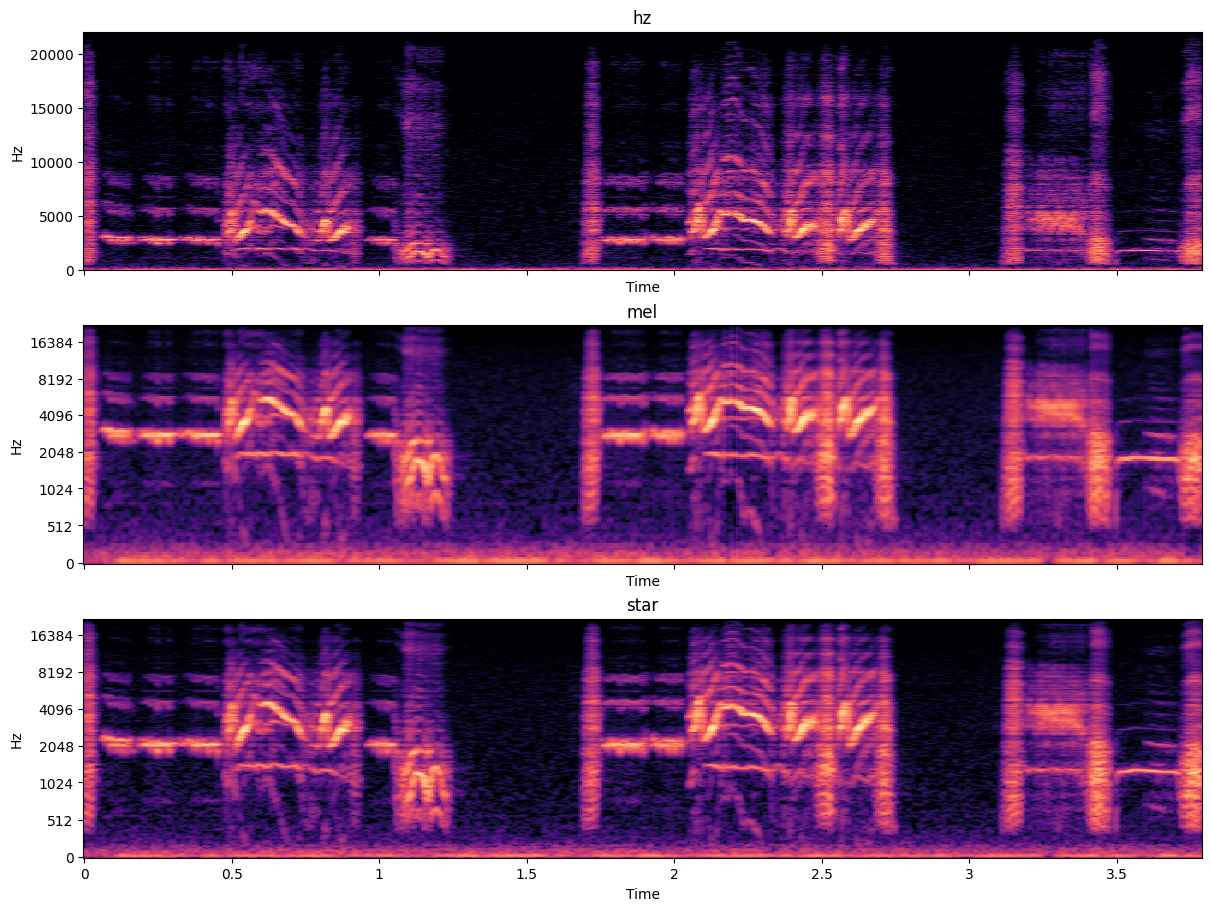

In [34]:
fig, ax = plt.subplots(figsize=(12, 9), nrows=3, ncols=1, sharex=True, constrained_layout=True)

for loc, spec_type, y in zip(np.arange(0, len(example_specs)), ['hz', 'mel', 'star'], ['hz', 'mel', 'mel']):
    img = librosa.display.specshow(
        example_specs[spec_type],
        hop_length = spec_pars['hop_length'],
        x_axis = 'time',
        y_axis = y,
        sr = 44100,
        ax = ax[loc]
    )
    ax[loc].set_title(spec_type)
    

### Save spectrograms in a pickle. 

In [35]:
spec_p = os.path.join(stable_length_folder, 'spec.p')

In [36]:
segs_df.head()

,seg,bID
0,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B335
1,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B335
2,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B335
3,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B335
4,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B335


In [37]:
def wav_to_spec(wav):
    '''
    Take a wav address and get a star spectrogram
    '''
    data, rate = librosa.load(wav) ## load as floating point
    spec = star_spectrogram(
        y = data,
        sr = rate,
        n_stars = spec_pars['n_stars'],
        n_fft = spec_pars['n_fft'],
        hop_length = spec_pars['hop_length'],
        win_length = spec_pars['n_fft'],
        window = 'hann'
    )
    spec = librosa.util.normalize(librosa.power_to_db(spec, ref = np.max))
    return spec

In [38]:
%%time
if os.path.exists(spec_p):
    apd.helpers.general.paragraph_print(f'Loading previously saved spectrograms', separation = '>')
    spec_p = pd.read_pickle(spec_p)
else:
    apd.helpers.general.paragraph_print(f'Writing spectrograms to {spec_p}', separation = '>')
    ## for each segment, transform to spec
    with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
        specs = parallel(
            delayed(wav_to_spec)(
                seg
            )
            for seg in tqdm(segs_df['seg'].values, desc = 'seg to spec...')
        )
    spec_lengths = [spec.shape[1] for spec in specs]
    min_spec_len = min(spec_lengths)
    segs_df['spec'] = [spec[:, :min_spec_len] for spec in specs]
    segs_df.to_pickle(spec_p)

Writing spectrograms to /mnt/cube/j8xing/kai_apd/data/interim/stable_length/spec.p
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


seg to spec...: 100%|██████████| 7000/7000 [00:26<00:00, 259.79it/s]


CPU times: user 19.7 s, sys: 10.6 s, total: 30.3 s
Wall time: 58.2 s


### Clean up memory

In [39]:
%reset -f